# The attention center model with OpenVINO™

This notebook demonstrates how to use the [attention center model](https://github.com/google/attention-center/tree/main) with OpenVINO. This model is in the [TensorFlow Lite format](https://www.tensorflow.org/lite), which is supported in OpenVINO now by TFlite frontend.

Eye tracking is commonly used in visual neuroscience and cognitive science to answer related questions such as visual attention and decision making. Computational models that predict where to look have direct applications to a variety of computer vision tasks. The attention center model takes an RGB image as input and return a 2D point as output. This 2D point is the predicted center of human attention on the image i.e. the most salient part of images, on which people pay attention fist to. This allows find the most visually salient regions and handle it as early as possible. For example, it could be used for the latest generatipon image format(such as [JPEG XL](https://github.com/libjxl/libjxl)), which supports encoding the parts that you pay attention to fist. It can help to improve user experience, image will appear to load faster.

Attention center model architecture is:
> The attention center model is a deep neural net, which takes an image as input, and uses a pre-trained classification network, e.g, ResNet, MobileNet, etc., as the backbone. Several intermediate layers that output from the backbone network are used as input for the attention center prediction module. These different intermediate layers contain different information e.g., shallow layers often contain low level information like intensity/color/texture, while deeper layers usually contain higher and more semantic information like shape/object. All are useful for the attention prediction. The attention center prediction applies convolution, deconvolution and/or resizing operator together with aggregation and sigmoid function to generate a weighting map for the attention center. And then an operator (the Einstein summation operator in our case) can be applied to compute the (gravity) center from the weighting map. An L2 norm between the predicted attention center and the ground-truth attention center can be computed as the training loss. Source: [google AI blogpost](https://opensource.googleblog.com/2022/12/open-sourcing-attention-center-model.html).

<img align='center' src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEjxLCDJHzJNjB_von-vFlq8TJJFA41aB85T-QE3ZNxW8kshAf3HOEyIEJ4uggXjbJmZhsdj7j6i6mvvmXtyaxXJPm3JHuKILNRTPfX9KvICbFBRD8KNuDVmLABzYuhQci3BT2BqV-wM54IxaoAV1YDBbnpJC92UZfEBGvakLusiqND2AaPpWPr2gJV1/s1600/image4.png" alt="drawing" width="80%"/>

The attention center model has been trained with images from the [COCO dataset](https://cocodataset.org/#home) annotated with saliency from the [salicon dataset](http://salicon.net/).


The tutorial consists of the following steps:
* Downloading the model
* Loading the model and make inference with OpenVINO API
* Run Live Attention Center Detection

## Imports

In [1]:
import cv2

import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

from openvino.tools import mo
from openvino.runtime import serialize, Core

2023-06-07 08:28:06.697504: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-07 08:28:06.734503: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 08:28:07.367300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Download the attention-center model

Download the model as part of [attention-center repo](https://github.com/google/attention-center/tree/main). The repo include model in folder `./model`. 

In [2]:
if not Path('./attention-center').exists():
    ! git clone https://github.com/google/attention-center

### Convert Tensorflow Lite model to OpenVINO IR format

The attention-center model is pre-trained model in TensorFlow Lite format. In this Notebook the model will be converted to 
OpenVINO IR format with Model Optimizer. This step will be skipped if the model have already been converted. For more information about Model Optimizer, please, see the [Model Optimizer Developer Guide]( https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html). 

Also TFLite models format is supported in OpenVINO by TFlite frontend, so the model can be passed directly to `core.read_model()`. You can find example in [002-openvino-api](https://github.com/openvinotoolkit/openvino_notebooks/tree/main/notebooks/002-openvino-api).

In [3]:
tflite_model_path = Path("./attention-center/model/center.tflite")

ir_model_path = Path("./model/ir_center_model.xml")

core = Core()

if not ir_model_path.exists():
    model = mo.convert_model(tflite_model_path)
    serialize(model, ir_model_path.as_posix())
    print("IR model saved to {}".format(ir_model_path))
else:
    print("Read IR model from {}".format(ir_model_path))
    model = core.read_model(ir_model_path)

device = "CPU"
compiled_model = core.compile_model(model=model, device_name=device)

Read IR model from model/ir_center_model.xml


## Prepare image to use with attention-center model

The attention-center model takes an RGB image with shape (480, 640) as input.

In [4]:
class Image():
    def __init__(self, model_input_image_shape, image_path=None, image=None):
        self.model_input_image_shape = model_input_image_shape
        self.image = None
        self.real_input_image_shape = None

        if image_path is not None:
            self.image = cv2.imread(str(image_path))
            self.real_input_image_shape = self.image.shape
        elif image is not None:
            self.image = image
            self.real_input_image_shape = self.image.shape
        else:
            raise Exception("Sorry, image can't be found, please, specify image_path or image")

    def prepare_image_tensor(self):
        rgb_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(rgb_image, (self.model_input_image_shape[1], self.model_input_image_shape[0]))

        image_tensor = tf.constant(np.expand_dims(resized_image, axis=0),
                                   dtype=tf.float32)
        return image_tensor

    def scalt_center_to_real_image_shape(self, predicted_center):
        new_center_y = round(predicted_center[0] * self.real_input_image_shape[1] / self.model_input_image_shape[1])
        new_center_x = round(predicted_center[1] * self.real_input_image_shape[0] / self.model_input_image_shape[0])
        return (int(new_center_y), int(new_center_x))

    def draw_attention_center_point(self, predicted_center):
        image_with_circle = cv2.circle(self.image,
                                       predicted_center,
                                       radius=10,
                                       color=(3, 3, 255),
                                       thickness=-1)
        return image_with_circle

    def print_image(self, predicted_center=None):
        image_to_print = self.image
        if predicted_center is not None:
            image_to_print = self.draw_attention_center_point(predicted_center)

        plt.imshow(cv2.cvtColor(image_to_print, cv2.COLOR_BGR2RGB))

## Load input image

Upload input image using file loading button

In [5]:
import ipywidgets as widgets

load_file_widget = widgets.FileUpload(
    accept="image/*", multiple=False, description="Image file",
)

load_file_widget

FileUpload(value=(), accept='image/*', description='Image file')

2023-06-07 08:28:10.155396: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


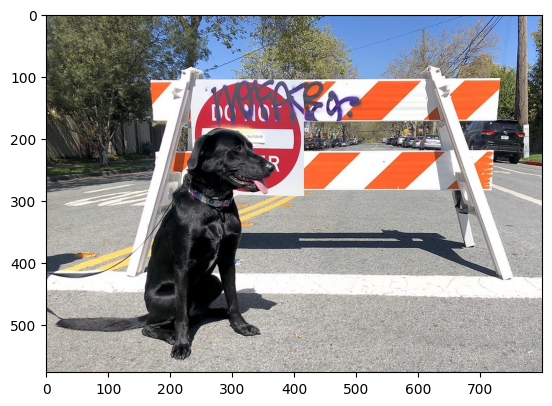

In [6]:
import io
import PIL
# read uploaded image
image = PIL.Image.open(io.BytesIO(load_file_widget.value[-1]['content'])) if load_file_widget.value else PIL.Image.open("../data/image/coco.jpg")
image.convert("RGB")

input_image = Image((480, 640), image=(np.ascontiguousarray(image)[:, :, ::-1]).astype(np.uint8))
image_tensor = input_image.prepare_image_tensor()
input_image.print_image()

## Get result with OpenVINO IR model

Prediction attention center point (292, 277)


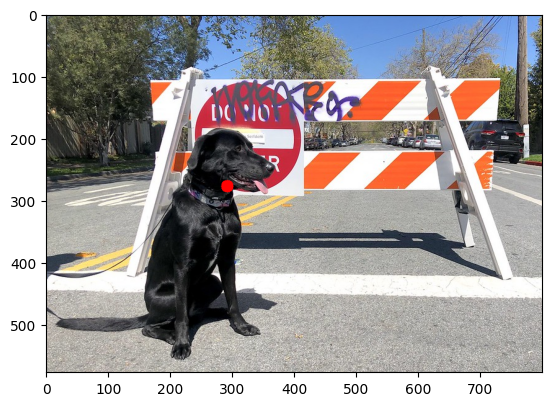

In [7]:
output_layer = compiled_model.output(0)

# make inference, get result in input image resolution
res = compiled_model([image_tensor])[output_layer]
# scale point to original image resulution
predicted_center = input_image.scalt_center_to_real_image_shape(res[0])
print(f'Prediction attention center point {predicted_center}')
input_image.print_image(predicted_center)